In [5]:
from collections import namedtuple
import csv
import math
import numpy as np
import matplotlib.pyplot as plt

# 横型ブラインドの斜入射特性を計算するモジュール

スラット材の形状とスラットの日射反射率から任意のプロファイル角における横型ブラインドの日射透過率及び日射反射率を計算する。

### 入力値  

$ W $ ：スラット幅 (m)  
$ d $ ：スラット高さ (m)  
$ S $ ：スラット間隔 (m)  
$ \rho_{upper,S} $：スラット材上面の日射反射率（鏡面反射成分）  
$ \rho_{upper,D} $：スラット材上面の日射反射率（拡散反射成分）  
$ \rho_{lower,S} $：スラット材下面の日射反射率（鏡面反射成分）  
$ \rho_{lower,D} $：スラット材下面の日射反射率（拡散反射成分）  
$ \psi $：スラット角 (°)  
$ \phi $：プロファイル角 (°)  

### 出力値
$ \tau_{\phi,f} $ ：横型ブラインドの正面側からの入射光に対するプロファイル角$\phi$の日射透過率  
$ \tau_{\phi,b} $ ：横型ブラインドの背面側からの入射光に対するプロファイル角$\phi$の日射透過率  
$ \rho_{\phi,f} $ ：横型ブラインドの正面側からの入射光に対するプロファイル角$\phi$の日射反射率  
$ \rho_{\phi,b} $ ：横型ブラインドの背面側からの入射光に対するプロファイル角$\phi$の日射反射率

### 計算方法  

#### データ構造と値の範囲  

$ W $・$ d $・$ S $・$ \rho_{upper,S} $・$ \rho_{upper,D} $・$ \rho_{lower,S} $・$ \rho_{lower,D} $・$ \psi $・$ \phi $の組み合わせを1つの変数（タプル）で表し"hbl_input"とする。  
$ \rho_{upper,S} $・$ \rho_{upper,D} $・$ \rho_{lower,S} $・$ \rho_{lower,D} $の値は0.0以上1.0以下の値をとる。  
$ \psi $・$ \phi $の値は-90°以上90°以下の値をとる。  

In [2]:
class hbl_input(namedtuple('hbl_input','hbl_W hbl_d hbl_S hbl_REFUS hbl_REFUD hbl_REFLS hbl_REFLD hbl_psi')):
    __slots__ = ()

#hbl_W：スラット幅 (m)
#hbl_d：スラット高さ (m) 
#hbl_S：スラット間隔 (m) 
#hbl_REFUS：スラット材上面の日射反射率（鏡面反射成分）
#hbl_REFUD：スラット材上面の日射反射率（拡散反射成分）
#hbl_REFLS：スラット材下面の日射反射率（鏡面反射成分）
#hbl_REFLD：スラット材下面の日射反射率（拡散反射成分）
#hbl_psi：スラット角 (°) 

$ \begin{align} Q_{m,(0)} = I･\cos \phi･\Delta L_{m} \end{align}$ ････････････････････････････････････････････ (1)

### 1. 鏡面反射

#### 光線の方向ベクトルの計算  

（参考：JIS A 2103：2014 附属書C ブラインドの光学特性の計算方法）  

光線の方向ベクトル$ \boldsymbol{s}_{(l)} $の計算式  
$ \begin{align}\boldsymbol{s}_{(l)} = \boldsymbol{s}_{(l-1)} + 2 \frac{\boldsymbol{s}_{(l-1)}･\boldsymbol{v}_{(i)}}{\bigl|\boldsymbol{v}_{(i)}\bigr|} \frac{\boldsymbol{v}_{(i)}}{\bigl|\boldsymbol{v}_{(i)}\bigr|}\end{align}$ ･･････････････････････ (C.5)  

（式(C.5)の補足説明）  

$ \begin{align}c = \bigl|\boldsymbol{s}_{(l-1)}\bigr| \cos \theta \end{align}$ ･･････････････････････ (1)  

内積の関係より、  

$ \begin{align}\cos \theta = \frac{\boldsymbol{s}_{(l-1)}･\boldsymbol{v}_{(i)}}{\bigl|\boldsymbol{s}_{(l-1)}\bigr|\bigl|\boldsymbol{v}_{(i)}\bigr|}\end{align}$ ･･････････････････････ (2)  

式(1)と式(2)より、

$ \begin{align}c = \frac{\boldsymbol{s}_{(l-1)}･\boldsymbol{v}_{(i)}}{\bigl|\boldsymbol{v}_{(i)}\bigr|} \end{align}$ ･･････････････････････ (3)  

次に、  

$ \begin{align}\boldsymbol{s}_{(l)} = -\boldsymbol{s}_{(l-1)} + 2c\frac{\boldsymbol{v}_{(i)}}{\bigl|\boldsymbol{v}_{(i)}\bigr|}\end{align}$ ･･････････････････････ (4)  

式(3)と式(4)より、  

$ \begin{align}\boldsymbol{s}_{(l)} = \boldsymbol{s}_{(l-1)} + 2 \frac{\boldsymbol{s}_{(l-1)}･\boldsymbol{v}_{(i)}}{\bigl|\boldsymbol{v}_{(i)}\bigr|} \frac{\boldsymbol{v}_{(i)}}{\bigl|\boldsymbol{v}_{(i)}\bigr|}\end{align}$ ･･････････････････････ (5)  

![image3.png][attached1]
[attached1]:img\image3.png  

0.0512 0.5056


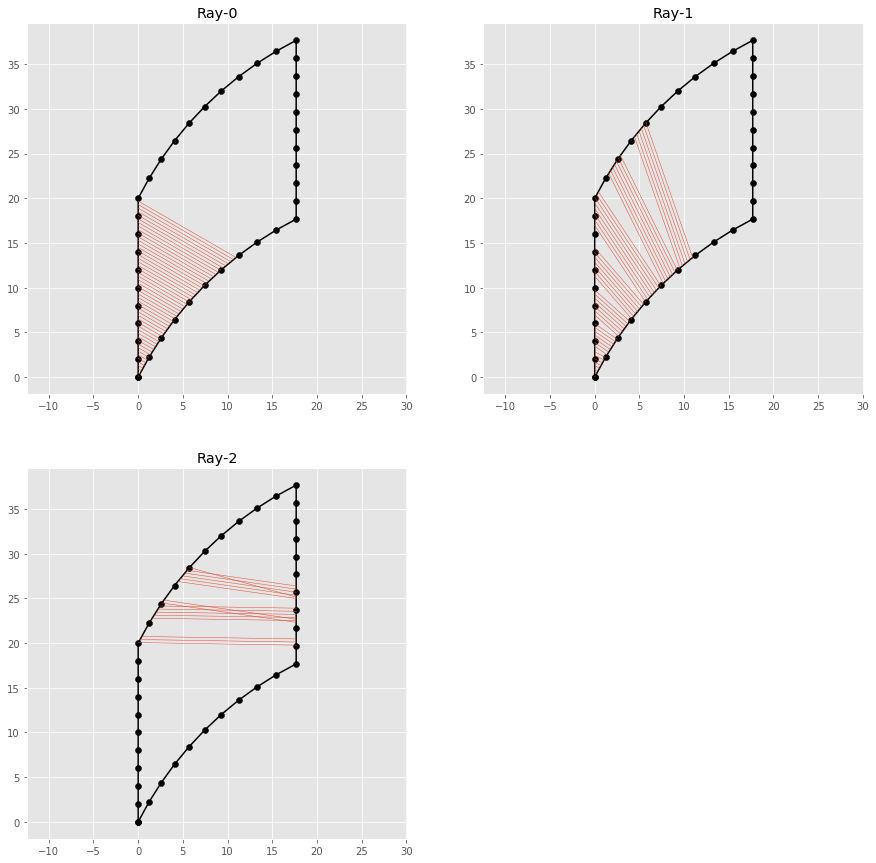

In [9]:
S = 20.                              #スラット間隔(mm)
W = 25.                              #スラット幅(mm)
d = 2.                               #スラット高さ(mm)
psi = 45.                            #スラット角(°)
rho_upper = 0.8                      #スラット材上面の反射率(鏡面)
rho_lower = 0.2                      #スラット材下面の反射率(鏡面)
phi = 30.                            #プロファイル角(°)

M = 100                              #入射開口の微小線分要素分割数
K = np.array([10, 10, 10, 10])       #領域境界の微小線分要素分割数(各境界)
Kall = np.sum(K)                     #領域境界の微小線分要素分割数(全境界)
L = 100                              #最大反射回数

#スラット高さがある場合のスラット円弧の計算
if d != 0:
    circle = np.empty((2, 3, 2), dtype=object)
    circle[0][0] = [0., 0.]                              #点A

    circle[0][1] = [W * np.cos(np.deg2rad(psi)), 
                    W * np.sin(np.deg2rad(psi))]       #点B

    circle[0][2] = [((W / 2) ** 2 + d ** 2) ** 0.5 * np.cos(np.arctan(d / (W / 2)) + np.deg2rad(psi)),
                    ((W / 2) ** 2 + d ** 2) ** 0.5 * np.sin(np.arctan(d / (W / 2)) + np.deg2rad(psi))]   #点F

    a = np.empty((3, 3), dtype=object)
    b = np.empty((3), dtype=object)
    x = np.empty((3), dtype=object)

    a[:, 0] = circle[0][:, 0]
    a[:, 1] = circle[0][:, 1]
    a[:, 2] = 1.
    b = -(circle[0][:, 0] ** 2. + circle[0][:, 1] ** 2.)

    a = a.astype(np.float64)
    b = b.astype(np.float64)

    x = np.linalg.solve(a,b)

    r = ((x[0] / 2) ** 2 + (x[1] / 2) ** 2 - x[2]) ** 0.5

    circle_o = [r * np.cos(np.deg2rad(90 - psi) - 2 * np.arctan(d / (W / 2))),
                -r * np.sin(np.deg2rad(90 - psi) - 2 * np.arctan(d / (W / 2)))]

    circle_theta = np.rad2deg(4 * np.arctan(d / (W / 2)))

#領域境界の分割要素の始点の位置ベクトル
q = np.empty((Kall + 1, 2), dtype=object)
for i in range(Kall + 1):
    if d == 0: #平板
        if i <= K[0]:                            #A-B間
            q[i] = [W / K[0] * i * np.cos(np.deg2rad(psi)), 
                    W / K[0] * i * np.sin(np.deg2rad(psi))]
        elif i <= (K[0] + K[1]):                 #B-C間
            q[i] = [q[K[0]][0], 
                    q[K[0]][1] + S / K[1] * (i - K[0])]
        elif i <= (K[0] + K[1] + K[2]):          #C-D間
            q[i] = [q[K[0] + K[1]][0] - W / K[2] * (i - K[0] - K[1]) * np.cos(np.deg2rad(psi)), 
                    q[K[0] + K[1]][1] - W / K[2] * (i - K[0] - K[1]) * np.sin(np.deg2rad(psi))]
        elif i <= (K[0] + K[1] + K[2] + K[3]):    #D-A間
            q[i] = [q[K[0] + K[1] + K[2]][0], 
                    q[K[0] + K[1] + K[2]][1] - S / K[3] * (i - K[0] - K[1] - K[2])]
    elif d != 0: #円弧
        if i <= K[0]:                            #A-B間
            q[i] = [circle_o[0] - r * np.cos((np.arctan(circle_o[1] / circle_o[0])) - np.deg2rad(circle_theta / K[0] * i)), 
                    circle_o[1] - r * np.sin((np.arctan(circle_o[1] / circle_o[0])) - np.deg2rad(circle_theta / K[0] * i))]
        elif i <= (K[0] + K[1]):                 #B-C間
            q[i] = [q[K[0]][0], 
                    q[K[0]][1] + S / K[1] * (i - K[0])]
        elif i <= (K[0] + K[1] + K[2]):          #C-D間
            q[i] = [q[K[0] + K[1]][0] + \
                    circle_o[0] - r * np.cos((np.arctan(circle_o[1] / circle_o[0])) - np.deg2rad(circle_theta) + \
                    np.deg2rad(circle_theta / K[2] * (i - K[0] - K[1]))) - W * np.cos(np.deg2rad(psi)), 
                    q[K[0] + K[1]][1] + \
                    circle_o[1] - r * np.sin((np.arctan(circle_o[1] / circle_o[0])) - np.deg2rad(circle_theta) + \
                    np.deg2rad(circle_theta / K[2] * (i - K[0] - K[1]))) - W * np.sin(np.deg2rad(psi))]
        elif i <= (K[0] + K[1] + K[2] + K[3]):    #D-A間
            q[i] = [q[K[0] + K[1] + K[2]][0], 
                    q[K[0] + K[1] + K[2]][1] - S / K[3] * (i - K[0] - K[1] - K[2])]
        
#領域境界の分割要素の方向ベクトル
v = np.empty((Kall, 2), dtype=object)
for i in range(Kall):
    v[i] = [q[i+1][0] - q[i][0], q[i+1][1] - q[i][1]]

l = 0
p = np.empty((M, L, 2), dtype=object)
s = np.empty((M, L, 2), dtype=object)
ipi = np.empty((M, L), dtype=object)
rc_upper = np.zeros(M)
rc_lower = np.zeros(M)
dir_ray = np.empty(M)
while l <= 10 and not (s[:,l-1] == 0).all():
    for m in range(M):
        if l == 0:
            #日射の始点の位置ベクトル(0回目)
            p[m][l] = [0, S / M * (m + 0.5)]            
            #日射の方向ベクトル(0回目)
            s[m][l] = [np.cos(np.deg2rad(phi)), -np.sin(np.deg2rad(phi))]
        elif l > 0:
            #日射の方向ベクトル(1回目以降)
            if (K[0] <= ipi[m][l-1] and ipi[m][l-1] <= (K[0] + K[1])):
                dir_ray[m] = 1 #透過
                s[m][l] = 0
            elif  ((K[0] + K[1] + K[2]) <= ipi[m][l-1] and ipi[m][l-1] <= Kall):
                dir_ray[m] = 0 #反射
                s[m][l] = 0
            else:
                s[m][l] = -s[m][l-1] + 2 * np.vdot(s[m][l-1], v[ipi[m][l-1]]) * v[ipi[m][l-1]] / \
                          (v[ipi[m][l-1]][0] ** 2. + v[ipi[m][l-1]][1] ** 2.)

    for m in range(M):
        for i in range(Kall):
            if (s[m][l] == 0).all():
                p[m][l + 1] = p[m][l]
                ipi[m][l] = ipi[m][l-1]
            else:
                if l == 0 or (l > 0 and i != ipi[m][l-1]):
                    deno = v[i][1] * s[m][l][0] - v[i][0] * s[m][l][1]
                    if deno != 0:
                        a = (v[i][0] * (p[m][l][1] - q[i][1]) - v[i][1] * (p[m][l][0] - q[i][0])) / deno
                        b = (s[m][l][0] * (p[m][l][1] - q[i][1]) - s[m][l][1] * (p[m][l][0] - q[i][0])) / deno

                        if 0 < a and 0 <= b and b < 1:
                            p[m][l + 1] = q[i] + b * v[i]
                            ipi[m][l] = i
                            if 0 <= i and i <= K[0]:
                                rc_upper[m] += 1
                            elif (K[0] + K[1]) <= i and i <= (K[0] + K[1] + K[2]):
                                rc_lower[m] += 1

    l += 1

attenuation = np.zeros(M)
for m in range(M):
    attenuation[m] = rho_upper ** rc_upper[m] * rho_lower ** rc_lower[m]

tau_tot = 0.
rho_tot = 0.
for m in range(M):
    tau_tot += attenuation[m] * dir_ray[m] / M #透過
    rho_tot += attenuation[m] * (1 - dir_ray[m]) / M #反射

print(tau_tot, rho_tot)

#グラフの描画
gx = np.empty((M, L, 2), dtype=object)
gy = np.empty((M, L, 2), dtype=object)
for ll in range(l):
    for m in range(0, M, 2):
        gx[m][ll] = [p[m][ll][0], p[m][ll + 1][0]]
        gy[m][ll] = [p[m][ll][1], p[m][ll + 1][1]]    

ax = np.empty(l, dtype = np.object) #
fig = plt.figure(figsize = (15, 7.5 * ((l + 1) // 2))) #
#fig = plt.figure(figsize = (10, 10))
plt.style.use('ggplot')
#plt.tick_params(labelsize=10)

for ll in range(l-1):   
    ax[ll] = fig.add_subplot((l+1) // 2, 2, ll + 1)
    #ax = fig.add_subplot(1, 1, 1)
    ax[ll].set_title('Ray-' + str(ll))
    ax[ll].scatter(q[:, 0], q[:, 1], color='k')
    ax[ll].plot(q[:, 0], q[:, 1], color='k')
    for m in range(M):
        ax[ll].plot(gx[m][ll], gy[m][ll], color='C0', linewidth=0.5)
    #ax.scatter(p[:, 1, 0], p[:, 1, 1], color='C0')
    plt.axis('equal')

plt.show()


#### 円弧スラットの微小線分要素の位置ベクトルと方向ベクトルの計算  


円の方程式

$\begin{align}x^2 + y^2 + l_0x + l_1y + l_2 = 0\end{align}$ ･･････････････････････ (1)  

式(1)を変形すると

$\begin{align}l_0x + l_1y + l_2 = -(x^2 + y^2)\end{align}$ ･･････････････････････ (2)  

点A、点B、点Fの3点の座標を通る外接円について考える。

それぞれの位置ベクトルは、次のように表すことができる。

$ 
\boldsymbol{A} = 
\begin{pmatrix} 
0 \\
0 \\
\end{pmatrix} 
$、
$ 
\boldsymbol{B} = 
\begin{pmatrix} 
W\cos\psi \\
W\sin\psi \\
\end{pmatrix} 
$、
$ 
\boldsymbol{F} = 
\begin{pmatrix} 
\sqrt{(0.5W)^2 + d^2} \cos\Bigl(\arctan\frac{d}{0.5W} + \psi\Bigl) \\
\sqrt{(0.5W)^2 + d^2} \sin\Bigl(\arctan\frac{d}{0.5W} + \psi\Bigl) \\
\end{pmatrix} 
$

3点の位置ベクトルを式(2)に代入して連立すると
               
$\begin{align}\boldsymbol{a}･\boldsymbol{l} = \boldsymbol{b}\end{align}$ ･･････････････････････ (3)
                      
ここで、

$ 
\boldsymbol{a} = 
\begin{pmatrix} 
0&0&1 \\
W\cos\psi&W\sin\psi&1 \\
\sqrt{(0.5W)^2 + d^2} \cos\Bigl(\arctan\frac{d}{0.5W} +\psi\Bigr)&\sqrt{(0.5W)^2 + d^2} \sin\Bigl(\arctan\frac{d}{0.5W} + \psi\Bigr)&1 \\
\end{pmatrix} 
$


$
\boldsymbol{l}
=
\begin{pmatrix} 
l_0 \\
l_1 \\
l_2 \\
\end{pmatrix}
$

$
\boldsymbol{b}
= 
\begin{pmatrix} 
0 \\
-(W\cos\psi^2 + \sin\psi^2) \\
-\Biggl(\biggl(\sqrt{(0.5W)^2 + d^2}\cos\Bigl(\arctan\frac{d}{0.5W} + \psi\Bigr)\biggr)^2 + 
        \biggl(\sqrt{(0.5W)^2 + d^2}\sin\Bigl(\arctan\frac{d}{0.5W} + \psi\Bigr)\biggr)^2\Biggr) \\
\end{pmatrix} 
$  

外接円の半径$r$は、 

$\begin{align}r = \sqrt{\Bigl(\frac{l_0}{2}\Bigr) ^ 2 + \Bigl(\frac{l_1}{2}\Bigr) ^ 2 - l_2} \end{align}$ ･･････････････････････ (4)


外接円の中心点Gの位置ベクトルは、次のように表すことができる。  

$ 
\boldsymbol{G} = 
\begin{pmatrix} 
r \cos\Bigl(90 - \psi - 2 \arctan\frac{d}{0.5W}\Bigr) \\
-r \sin\Bigl(90 - \psi - 2 \arctan\frac{d}{0.5W}\Bigr) \\
\end{pmatrix} 
$

円弧の領域境界の微小要素の位置ベクトルは、次のように表すことができる。  

$0 \leq i \leq K_0$の場合、  

$ 
\boldsymbol{q}_i = 
\begin{pmatrix} 
\boldsymbol{G}_x - r \cos\Bigl(\arctan\frac{\boldsymbol{G}_y}{\boldsymbol{G}_x} - \frac{i}{K_0}\theta\Bigr) \\
\boldsymbol{G}_y - r \sin\Bigl(\arctan\frac{\boldsymbol{G}_y}{\boldsymbol{G}_x} - \frac{i}{K_0}\theta\Bigr) \\
\end{pmatrix} 
$

$K_0 < i \leq (K_0 + K_1)$の場合、  

$ 
\boldsymbol{q}_i = 
\begin{pmatrix} 
\boldsymbol{q}_{K_0,x} \\
\boldsymbol{q}_{K_0,y} - \frac{i - K_0}{K_1}S \\
\end{pmatrix} 
$

$(K_0 + K_1) < i \leq (K_0 + K_1 + K_2)$の場合、  

$ 
\boldsymbol{q}_i = 
\begin{pmatrix} 
\boldsymbol{q}_{(K_0 + K_1),x} + \boldsymbol{G}_x - r\cos\Bigl(\arctan\frac{\boldsymbol{G}_y}{\boldsymbol{G}_x} + \frac{i - K_0 - K_1 - K_2}{K_2}\theta\Bigr) - W\cos\psi \\
\boldsymbol{q}_{(K_0 + K_1),y} + \boldsymbol{G}_y - r\sin\Bigl(\arctan\frac{\boldsymbol{G}_y}{\boldsymbol{G}_x} + \frac{i - K_0 - K_1 - K_2}{K_2}\theta\Bigr) - W\sin\psi \\
\end{pmatrix} 
$

$(K_0 + K_1 + K_2) < i \leq (K_0 + K_1 + K_2 + K_3)$の場合、  

$ 
\boldsymbol{q}_i = 
\begin{pmatrix} 
\boldsymbol{q}_{(K_0 + K_1 + K_2),x} \\
\boldsymbol{q}_{(K_0 + K_1 + K_2),y} - \frac{i - K_0 - K_1 - K_2}{K_3}S \\
\end{pmatrix} 
$


0.0512 0.5056


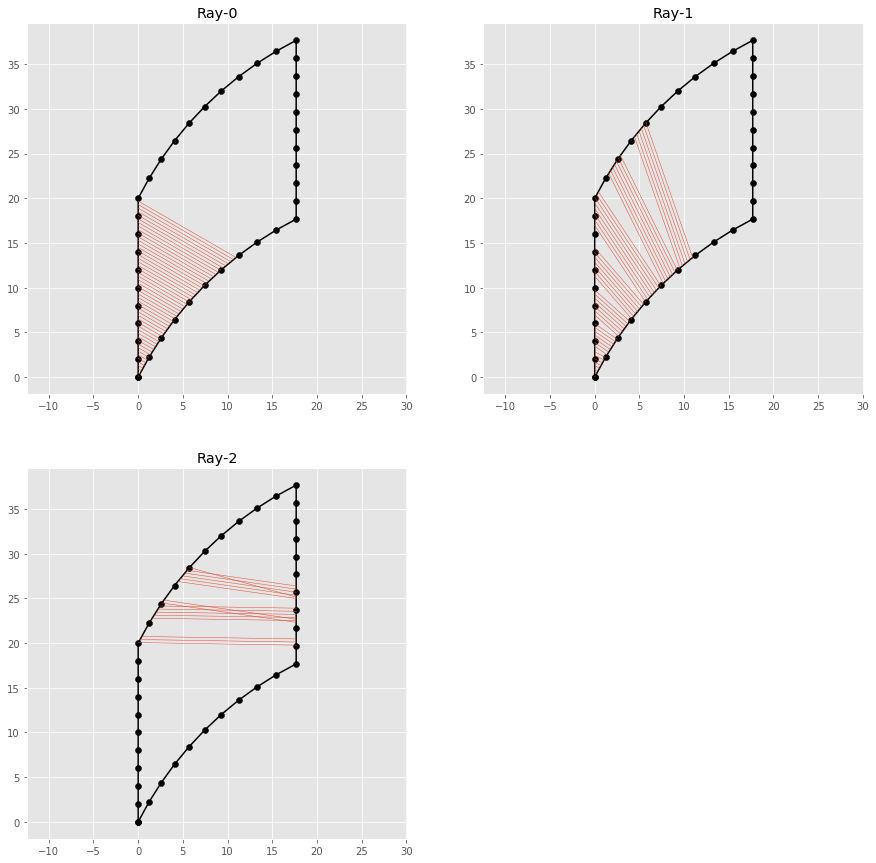

In [6]:
S = 20.                              #スラット間隔(mm)
W = 25.                              #スラット幅(mm)
d = 2.                               #スラット高さ(mm)
psi = 45.                            #スラット角(°)
rho_upper = 0.8                      #スラット材上面の反射率(鏡面)
rho_lower = 0.2                      #スラット材下面の反射率(鏡面)
phi = 30.                            #プロファイル角(°)

M = 100                              #入射開口の微小線分要素分割数
K = np.array([10, 10, 10, 10])       #領域境界の微小線分要素分割数(各境界)
Kall = np.sum(K)                     #領域境界の微小線分要素分割数(全境界)
L = 100                              #最大反射回数

#スラット高さがある場合のスラット円弧の計算
if d != 0:
    cir_a = np.empty((3, 3), dtype=object)
    cir_b = np.empty((3), dtype=object)
    cir_l = np.empty((3), dtype=object)
    
    cir_a = np.array([[0., 0., 1.],
                     [W * np.cos(np.deg2rad(psi)), W * np.sin(np.deg2rad(psi)), 1.],
                     [((W / 2) ** 2 + d ** 2) ** 0.5 * np.cos(np.arctan(d / (W / 2)) + np.deg2rad(psi)), 
                      ((W / 2) ** 2 + d ** 2) ** 0.5 * np.sin(np.arctan(d / (W / 2)) + np.deg2rad(psi)), 1.]])
    
    cir_b = -(cir_a[:, 0] ** 2 + cir_a[:, 1] ** 2)

    cir_a = cir_a.astype(np.float64)
    cir_b = cir_b.astype(np.float64)
    cir_l = np.linalg.solve(cir_a, cir_b)
    
    cir_r = ((cir_l[0] / 2) ** 2 + (cir_l[1] / 2) ** 2 - cir_l[2]) ** 0.5

    cir_o = [cir_r * np.cos(np.deg2rad(90 - psi) - 2 * np.arctan(d / (W / 2))),
             -cir_r * np.sin(np.deg2rad(90 - psi) - 2 * np.arctan(d / (W / 2)))]

    cir_theta = np.rad2deg(4 * np.arctan(d / (W / 2)))
    
#領域境界の分割要素の始点の位置ベクトル
q = np.empty((Kall + 1, 2), dtype=object)
for i in range(Kall + 1):
    if d == 0: #平板
        if i <= K[0]:                            #A-B間
            q[i] = [W / K[0] * i * np.cos(np.deg2rad(psi)), 
                    W / K[0] * i * np.sin(np.deg2rad(psi))]
        elif i <= (K[0] + K[1]):                 #B-C間
            q[i] = [q[K[0]][0], 
                    q[K[0]][1] + S / K[1] * (i - K[0])]
        elif i <= (K[0] + K[1] + K[2]):          #C-D間
            q[i] = [q[K[0] + K[1]][0] - W / K[2] * (i - K[0] - K[1]) * np.cos(np.deg2rad(psi)), 
                    q[K[0] + K[1]][1] - W / K[2] * (i - K[0] - K[1]) * np.sin(np.deg2rad(psi))]
        elif i <= (K[0] + K[1] + K[2] + K[3]):    #D-A間
            q[i] = [q[K[0] + K[1] + K[2]][0], 
                    q[K[0] + K[1] + K[2]][1] - S / K[3] * (i - K[0] - K[1] - K[2])]
    elif d != 0: #円弧
        if i <= K[0]:                            #A-B間
            q[i] = [cir_o[0] - cir_r * np.cos((np.arctan(cir_o[1] / cir_o[0])) - np.deg2rad(cir_theta / K[0] * i)), 
                    cir_o[1] - cir_r * np.sin((np.arctan(cir_o[1] / cir_o[0])) - np.deg2rad(cir_theta / K[0] * i))]
        elif i <= (K[0] + K[1]):                 #B-C間
            q[i] = [q[K[0]][0], 
                    q[K[0]][1] + S / K[1] * (i - K[0])]
        elif i <= (K[0] + K[1] + K[2]):          #C-D間
            q[i] = [q[K[0] + K[1]][0] + cir_o[0] - cir_r * np.cos((np.arctan(cir_o[1] / cir_o[0])) + \
                    np.deg2rad(cir_theta / K[2] * (i - K[0] - K[1] - K[2]))) - W * np.cos(np.deg2rad(psi)), 
                    q[K[0] + K[1]][1] + cir_o[1] - cir_r * np.sin((np.arctan(cir_o[1] / cir_o[0])) + \
                    np.deg2rad(cir_theta / K[2] * (i - K[0] - K[1] - K[2]))) - W * np.sin(np.deg2rad(psi))]

#                    cir_o[0] - cir_r * np.cos((np.arctan(cir_o[1] / cir_o[0])) - np.deg2rad(cir_theta) + \
#                    np.deg2rad(cir_theta / K[2] * (i - K[0] - K[1]))) - W * np.cos(np.deg2rad(psi)), 
#                    q[K[0] + K[1]][1] + \
#                    cir_o[1] - cir_r * np.sin((np.arctan(cir_o[1] / cir_o[0])) - np.deg2rad(cir_theta) + \
#                    np.deg2rad(cir_theta / K[2] * (i - K[0] - K[1]))) - W * np.sin(np.deg2rad(psi))]
        elif i <= (K[0] + K[1] + K[2] + K[3]):    #D-A間
            q[i] = [q[K[0] + K[1] + K[2]][0], 
                    q[K[0] + K[1] + K[2]][1] - S / K[3] * (i - K[0] - K[1] - K[2])]
        
#領域境界の分割要素の方向ベクトル
v = np.empty((Kall, 2), dtype=object)
for i in range(Kall):
    v[i] = [q[i+1][0] - q[i][0], q[i+1][1] - q[i][1]]

l = 0
p = np.empty((M, L, 2), dtype=object)
s = np.empty((M, L, 2), dtype=object)
ipi = np.empty((M, L), dtype=object)
rc_upper = np.zeros(M)
rc_lower = np.zeros(M)
dir_ray = np.empty(M)
while l <= 10 and not (s[:,l-1] == 0).all():
    for m in range(M):
        if l == 0:
            #日射の始点の位置ベクトル(0回目)
            p[m][l] = [0, S / M * (m + 0.5)]            
            #日射の方向ベクトル(0回目)
            s[m][l] = [np.cos(np.deg2rad(phi)), -np.sin(np.deg2rad(phi))]
        elif l > 0:
            #日射の方向ベクトル(1回目以降)
            if (K[0] <= ipi[m][l-1] and ipi[m][l-1] <= (K[0] + K[1])):
                dir_ray[m] = 1 #透過
                s[m][l] = 0
            elif  ((K[0] + K[1] + K[2]) <= ipi[m][l-1] and ipi[m][l-1] <= Kall):
                dir_ray[m] = 0 #反射
                s[m][l] = 0
            else:
                s[m][l] = -s[m][l-1] + 2 * np.vdot(s[m][l-1], v[ipi[m][l-1]]) * v[ipi[m][l-1]] / \
                          (v[ipi[m][l-1]][0] ** 2. + v[ipi[m][l-1]][1] ** 2.)

    for m in range(M):
        for i in range(Kall):
            if (s[m][l] == 0).all():
                p[m][l + 1] = p[m][l]
                ipi[m][l] = ipi[m][l-1]
            else:
                if l == 0 or (l > 0 and i != ipi[m][l-1]):
                    deno = v[i][1] * s[m][l][0] - v[i][0] * s[m][l][1]
                    if deno != 0:
                        a = (v[i][0] * (p[m][l][1] - q[i][1]) - v[i][1] * (p[m][l][0] - q[i][0])) / deno
                        b = (s[m][l][0] * (p[m][l][1] - q[i][1]) - s[m][l][1] * (p[m][l][0] - q[i][0])) / deno

                        if 0 < a and 0 <= b and b < 1:
                            p[m][l + 1] = q[i] + b * v[i]
                            ipi[m][l] = i
                            if 0 <= i and i <= K[0]:
                                rc_upper[m] += 1
                            elif (K[0] + K[1]) <= i and i <= (K[0] + K[1] + K[2]):
                                rc_lower[m] += 1

    l += 1

attenuation = np.zeros(M)
for m in range(M):
    attenuation[m] = rho_upper ** rc_upper[m] * rho_lower ** rc_lower[m]

tau_tot = 0.
rho_tot = 0.
for m in range(M):
    tau_tot += attenuation[m] * dir_ray[m] / M #透過
    rho_tot += attenuation[m] * (1 - dir_ray[m]) / M #反射

print(tau_tot, rho_tot)

#グラフの描画
gx = np.empty((M, L, 2), dtype=object)
gy = np.empty((M, L, 2), dtype=object)
for ll in range(l):
    for m in range(0, M, 2):
        gx[m][ll] = [p[m][ll][0], p[m][ll + 1][0]]
        gy[m][ll] = [p[m][ll][1], p[m][ll + 1][1]]    

ax = np.empty(l, dtype = np.object) #
fig = plt.figure(figsize = (15, 7.5 * ((l + 1) // 2))) #
#fig = plt.figure(figsize = (10, 10))
plt.style.use('ggplot')
#plt.tick_params(labelsize=10)

for ll in range(l-1):   
    ax[ll] = fig.add_subplot((l+1) // 2, 2, ll + 1)
    #ax = fig.add_subplot(1, 1, 1)
    ax[ll].set_title('Ray-' + str(ll))
    ax[ll].scatter(q[:, 0], q[:, 1], color='k')
    ax[ll].plot(q[:, 0], q[:, 1], color='k')
    for m in range(M):
        ax[ll].plot(gx[m][ll], gy[m][ll], color='C0', linewidth=0.5)
    #ax.scatter(p[:, 1, 0], p[:, 1, 1], color='C0')
    plt.axis('equal')

plt.show()


In [ ]:
40.0625
0.0512 0.5056